## План работы

[1. Подготовка данных](#1.)<br>
[2. Обучение моделей и поиск лучших гиперпараметров](#2.)<br>
[3. Финальное тестирование и анализ моделей](#3.)<br>

# 1. Подготовка и анализ данных <a id = "1."> </a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings('ignore') 
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
%matplotlib inline

taxi = pd.read_csv(r'E:\Документы прочие\IT\Яндекс практикум\Project\10 Временные ряды\taxi.csv', 
                   parse_dates=[0], index_col=[0])

def data_info(data):
    '''
    Функция принимает в качестве аргументов датасет.
    Функция выводит информацию о датасете и первые 10 строк датасета, а также количество дубликатов.
    '''
    data.info()
    display(data.head(10))
    
def hist(data, c, t, b):
    '''
    Функция принимает в качестве аргументов: датасет, колонку датасета, название гистрограммы, количество корзин.
    Функция выводит гистрограмму.
    '''
    plt.figure(figsize=(15, 10))
    plt.title(t, fontsize=15)
    sns.distplot(data[c], bins=b, kde=True)

def box_plt(data, c, t):
    '''
    Функция принимает в качестве аргументов: датасет, колонку датасета, название диаграммы.
    Функция выводит диаграмму ящик с усами.
    '''
    plt.figure(figsize=(15,10))
    sns.boxplot(data = data[c])
    plt.title(t, fontsize=15)
    plt.grid(True)
    plt.show()
    
def min_max(data, c):
    '''
    Функция принимает в качестве аргументов: датасет, колонку датасета.
    Функция выводит минимальное и максимальное значение.
    '''
    print('Min:', data[c].min())
    print('Max:', data[c].max())

def decompose_plots(data):
    '''
    Функция принимает в качестве аргументов: датасет.
    Функция раскладывает временной ряд на три составляющие: тренд, сезонность и остаток.
    '''
    decomposed = seasonal_decompose(data)
    plt.figure(figsize=(15, 10))
    plt.subplot(311)
    # Чтобы график корректно отобразился, указываем его
    # оси ax, равными plt.gca() (англ. get current axis,
    # получить текущие оси)
    decomposed.trend.plot(ax=plt.gca())
    plt.title('Trend')
    plt.subplot(312)
    decomposed.seasonal.plot(ax=plt.gca())
    plt.title('Seasonality')
    plt.subplot(313)
    decomposed.resid.plot(ax=plt.gca())
    plt.title('Residuals')
    plt.tight_layout()

Мы будем использовать датасет taxi, который содержит исторические данные о заказах такси в аэропортах.

In [2]:
data_info(taxi)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


Датасет taxi размером в 26496 строк содержит 1 колоноку с количеством заказов, проиндексированную по времени с интервалом в 10 минут. Общий временной интервал с 01.03.2018 по 31.08.2018. Данные не содержат пропусков. Проведем ресемплирование и увеличим интервал до 1 часа по суммарному значению.

In [3]:
taxi = taxi.sort_index().resample('1H').sum()
data_info(taxi)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


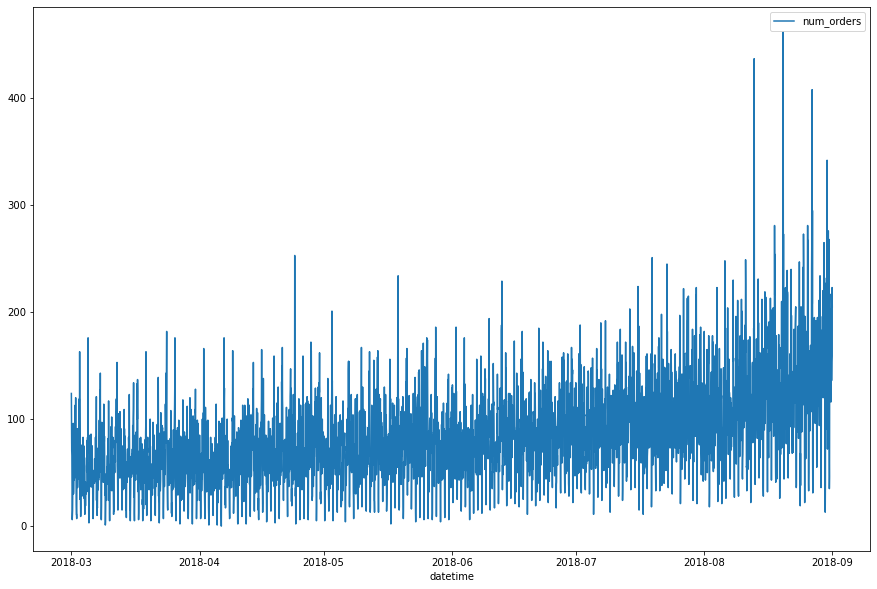

In [4]:
plt.figure(figsize=(15,10))
sns.lineplot(data = taxi)

Проанализируем распределение заказов.

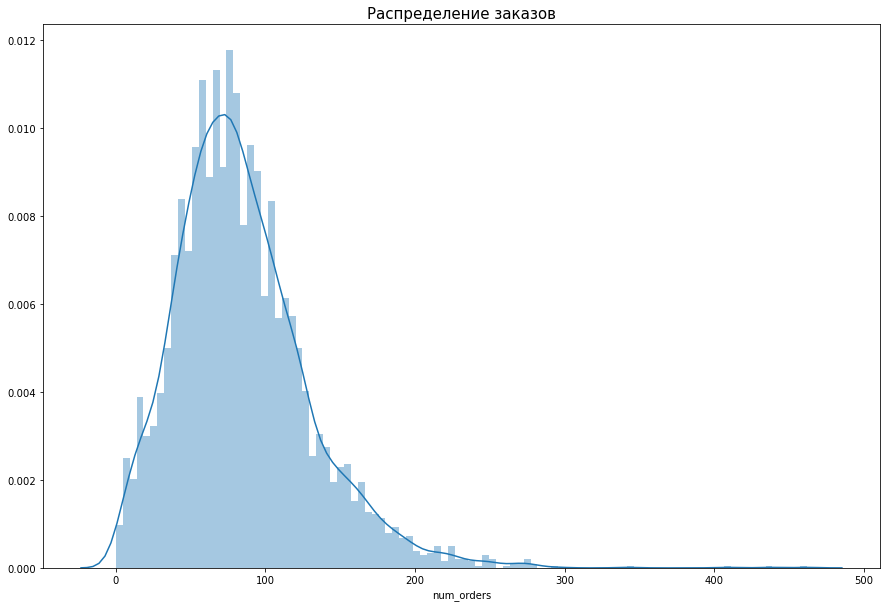

In [5]:
hist(taxi, 'num_orders', 'Распределение заказов', 100)

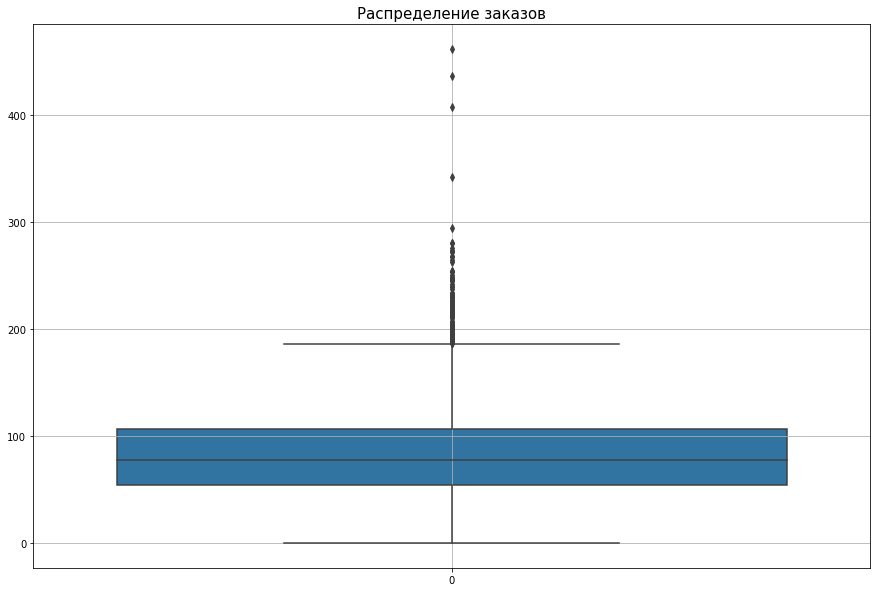

In [6]:
box_plt(taxi, 'num_orders', 'Распределение заказов')

In [7]:
min_max(taxi, 'num_orders')

Min: 0
Max: 462


Распределение близко к нормальному виду и смещено влево. В данных содержаться выбросы - время в которое было очень большое количество заказов такси. 

Разложим временной ряд на три составляющие: тренд, сезонность и остаток(шум - компонента, которая не объясняется трендом и сезонностью).

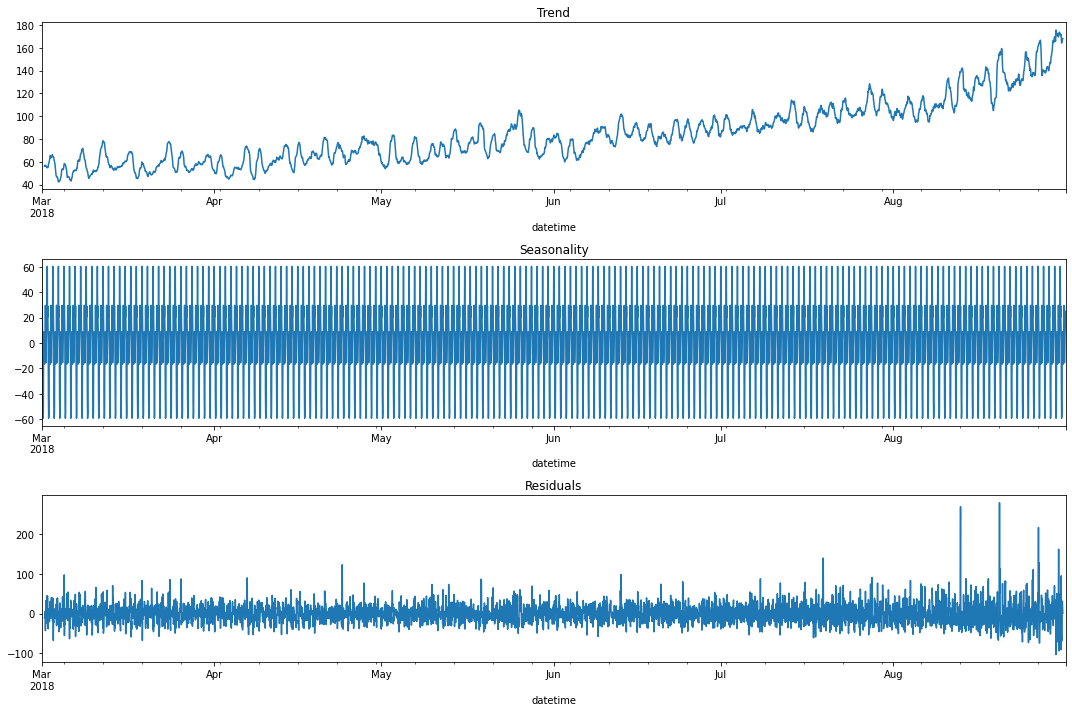

In [8]:
decompose_plots(taxi)

Из полученных графиков мы видим, что количество заказов увеличивается с марта по август. Также в данных присутствует сезонная составляющая и некоторое количество шумов.

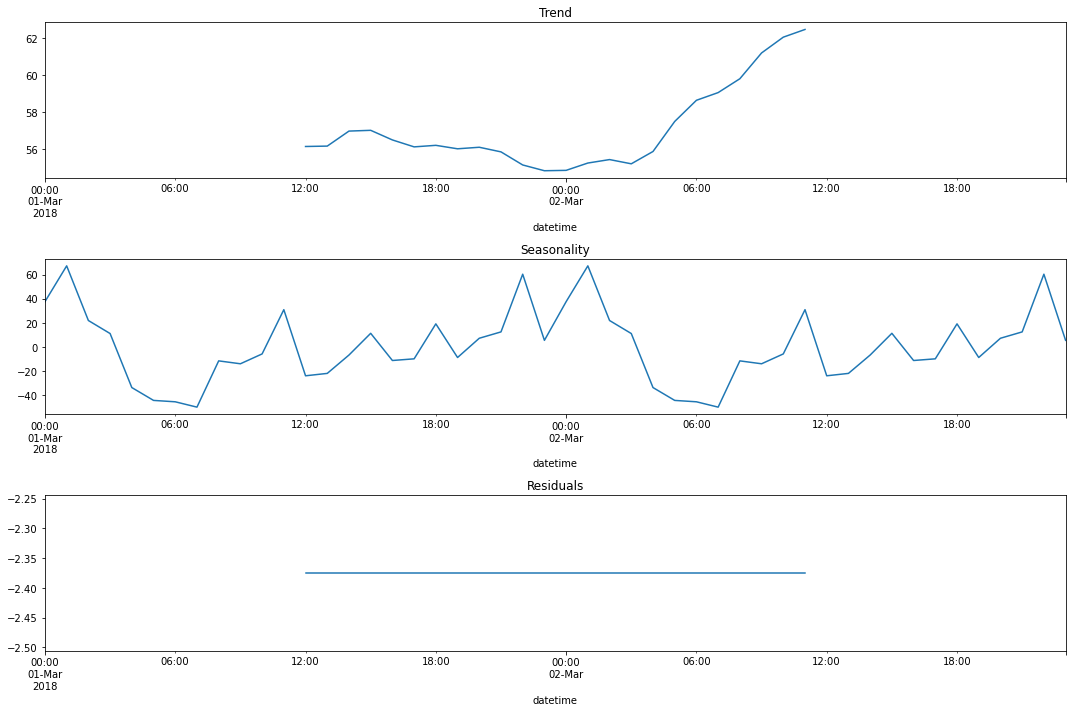

In [9]:
decompose_plots(taxi['2018-03-01':'2018-03-02'])

Проанализировав сезонную составляющую мы выяснили, что количество заказов ежедневно растет и достигает дневного максимума в районе 00:00-00:30 и затем снижается до минимума в районе 05:30-06:30.

### Вывод

Была изучена общая информация о полученных данных. В данных отсутствуют пропуски и дубликаты. Распределение имеет нормальный вид и смещено влево, в данных содержаться выбросы (шумы).

# 2. Обучение моделей и поиск лучших гиперпараметров <a id = "2."> </a>

Подготовим данные для обучения:
- выделим из данных дополнительные признаки
- разобьем датасет на обучающую и тестовую выборки (тестовая выборка 10%)
- выделим у обучающей и тестовой выборки признаки и целевой признак

In [10]:
def prepareData(data, lag_start, lag_end, test_size, rolling_mean_size):
    '''
    Функция принимает в качестве аргументов: датасет, начало и конец лага,
    размер тестовой выборки, размер окна для скользящего среднего.
    Функция добавляет признаки в датасет, очищает его от пропусков, 
    разбивает выборку на обучающую и тестовую и выделяет у них признаки и целевой признак.
    '''
    data = pd.DataFrame(data.copy())
    data.columns = ['y']

    data['rolling_mean'] = data['y'].shift().rolling(rolling_mean_size).mean()    
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)

    data['hour'] = data.index.hour
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['month'] = data.index.month
    
    # очищаем пропуски
    data = data.dropna()
    data = data.reset_index(drop=True)
    
    # разбиваем весь датасет на обучающую и тестовую выборки
    train, test = train_test_split(data, test_size = test_size, shuffle=False)
    
    # выделим у обучающей и тестовой выборки признаки и целевой признак
    X_train = train.drop(['y'], axis=1)
    y_train = train['y']
    X_test = test.drop(['y'], axis=1)
    y_test = test['y']

    return X_train, X_test, y_train, y_test

In [11]:
X_train, X_test, y_train, y_test = prepareData(taxi, 1, 16, 0.1, 10)

Вычислим наилучшую метрику RMSE на кросс-валидации и подберем для моделей наилучшие гиперпараметры. Кросс-валидацию мы будем проводить с помощью TimeSeriesSplit, которая учитывает расположение фолдов и не меняет их местами, как при обычной кросс-валидации.

In [12]:
tscv = TimeSeriesSplit(n_splits=3)

В данных присутствуют колличественные признаки с разными разбросами значений. Для того, чтобы алгоритм не решил, что признаки с большими значениями и разбросом важнее, маcштабируем количественные признаки.

In [13]:
numeric = ['rolling_mean'] + X_train.columns[X_train.columns.str.contains('lag')].to_list()
scaler = MinMaxScaler()
scaler.fit(X_train[numeric])
# масштабируем обучающую выборку
X_train[numeric] = scaler.transform(X_train[numeric])
# масштабируем тестовую выборку
X_test[numeric] = scaler.transform(X_test[numeric])

### LinearRegression

In [14]:
def lr_gridsearchcv(features, target):
    '''
    Функция принимает в качестве аргументов: признаки и целевой признак для обучения.
    Функция выдает словарь с лучшими гиперпараметрами и лучшее значение метрики для модели линейной регрессии.
    '''
    model = LinearRegression()
    param_grid = {
        'fit_intercept' : [True, False],
    }
    CV = GridSearchCV(estimator = model, param_grid = param_grid, cv= tscv,  scoring = 'neg_root_mean_squared_error')
    CV.fit(features, target)
    print('Лучшие гиперпараметры: ', CV.best_params_)
    print('Лучшее RMSE: {:.2f}'.format(-CV.best_score_))
    return CV.best_params_     

In [15]:
%%time
best_params_lr = lr_gridsearchcv(X_train, y_train)

Лучшие гиперпараметры:  {'fit_intercept': False}
Лучшее RMSE: 32.19
Wall time: 50 ms


### RandomForestRegressor

In [16]:
def rfr_gridsearchcv(features, target):
    '''
    Функция принимает в качестве аргументов: признаки и целевой признак для обучения.
    Функция выдает словарь с лучшими гиперпараметрами и лучшее значение метрики для модели случайного леса регрессии.
    '''
    model = RandomForestRegressor()
    param_grid = {
        'random_state': [42],
        'n_estimators': range(1,201,40),
        'max_features': ['auto', 'sqrt', 'log2', None],
        'max_depth' : [range(1,10,1), None]
    }
    CV = GridSearchCV(estimator = model, param_grid = param_grid, cv= tscv,  scoring = 'neg_root_mean_squared_error')
    CV.fit(features, target)
    print('Лучшие гиперпараметры: ', CV.best_params_)
    print('Лучшее RMSE: {:.2f}'.format(-CV.best_score_))
    return CV.best_params_ 

In [17]:
%%time
best_params_rfr = rfr_gridsearchcv(X_train, y_train)

Лучшие гиперпараметры:  {'max_depth': None, 'max_features': 'auto', 'n_estimators': 161, 'random_state': 42}
Лучшее RMSE: 26.86
Wall time: 1min 2s


### KNeighborsRegressor

In [18]:
def knn_gridsearchcv(features, target):
    '''
    Функция принимает в качестве аргументов: признаки и целевой признак для обучения.
    Функция выдает словарь с лучшими гиперпараметрами и лучшее значение метрики для модели k ближайших соседей.
    '''
    model = KNeighborsRegressor()
    param_grid = {
        'n_neighbors' : range(1,5,1),
        'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
    }
    CV = GridSearchCV(estimator = model, param_grid = param_grid, cv= tscv, scoring = 'neg_root_mean_squared_error')
    CV.fit(features, target)
    print('Лучшие гиперпараметры: ', CV.best_params_)
    print('Лучшее RMSE: {:.2f}'.format(-CV.best_score_))
    return CV.best_params_ 

In [19]:
%%time
best_params_knn = knn_gridsearchcv(X_train, y_train)

Лучшие гиперпараметры:  {'algorithm': 'auto', 'n_neighbors': 4}
Лучшее RMSE: 33.24
Wall time: 1.17 s


### LGBMRegressor

In [20]:
def lgbm_gridsearchcv(features, target):
    '''
    Функция принимает в качестве аргументов: признаки и целевой признак для обучения.
    Функция выдает словарь с лучшими гиперпараметрами и лучшее значение метрики для модели LGBMRegressor.
    '''
    model = lgb.LGBMRegressor()
    param_grid = {
            'boosting_type': ['gbdt', 'dart', 'goss', 'rf'],
            'objective': ['regression'],
            'metric': ['rmse'],
            'n_estimators': [400],
            'learning_rate': [0.03, 0.1, 0.15],
            'max_depth': np.arange(4, 7),
            'random_state': [42],
    }
    CV = GridSearchCV(estimator = model, param_grid = param_grid, cv= tscv, scoring = 'neg_root_mean_squared_error')
    CV.fit(features, target)
    print('Лучшие гиперпараметры: ', CV.best_params_)
    print('Лучшее RMSE: {:.2f}'.format(-CV.best_score_))
    return CV.best_params_ 

In [21]:
%%time
best_param_lgbm = lgbm_gridsearchcv(X_train, y_train)

Лучшие гиперпараметры:  {'boosting_type': 'gbdt', 'learning_rate': 0.03, 'max_depth': 5, 'metric': 'rmse', 'n_estimators': 400, 'objective': 'regression', 'random_state': 42}
Лучшее RMSE: 26.53
Wall time: 30 s


### Вывод

Мы провели кросс-валидацию обучающей выборки и подобрали для моделей лучшие гиперпараметры. Лучшее значение RMSE на обучающей выборке показала модель LGBMRegressor. Быстрее всех подобрала параметры модель LinearRegression.

# 3. Финальное тестирование и анализ моделей <a id = "3."> </a>

In [22]:
def ml(model, features_train, target_train, features_test, target_test):
    '''
    Функция принимает в качестве аргументов: модель, признаки и целевой признак выборки для обучения и тестирования.
    Функция обучает заданную модель по обучающей выборке и расчитывает метрику RMSE по тестовой выборке.
    '''
    model.fit(features_train, target_train)
    predictions = model.predict(features_test)
    rmse = mean_squared_error(predictions, target_test)**0.5
    print('RMSE модели:',rmse)
    time_series_true_pred_plot(predictions, target_test)
    
def time_series_true_pred_plot(predictions, y_test):
    '''
    Функция принимает в качестве аргументов: предсказания и ответы.
    Функция строит график предсказаний и ответов.
    '''
    plt.figure(figsize=(15, 7))
    plt.plot(predictions, 'r', label = 'prediction')
    plt.plot(y_test.values, label = 'actual')
    plt.legend(loc = 'best')
    metric = round(mean_squared_error(predictions, y_test)**0.5, 2)
    plt.title('RMSE {} orders'.format(metric))
    plt.grid(True)

Проанализируем обученные модели на тестовой выборке.

### LinearRegression

RMSE модели: 54.148177954910345


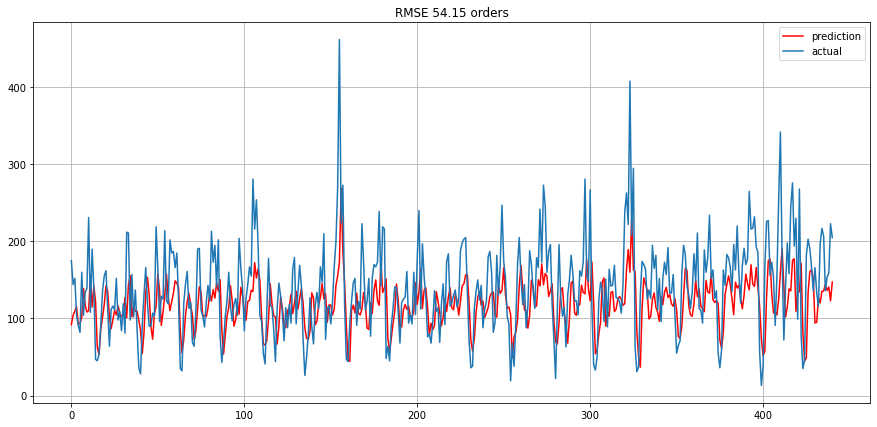

In [23]:
model_lr = LinearRegression(**best_params_lr)
ml(model_lr, X_train, y_train, X_test, y_test)

### RandomForestRegressor

RMSE модели: 54.148177954910345


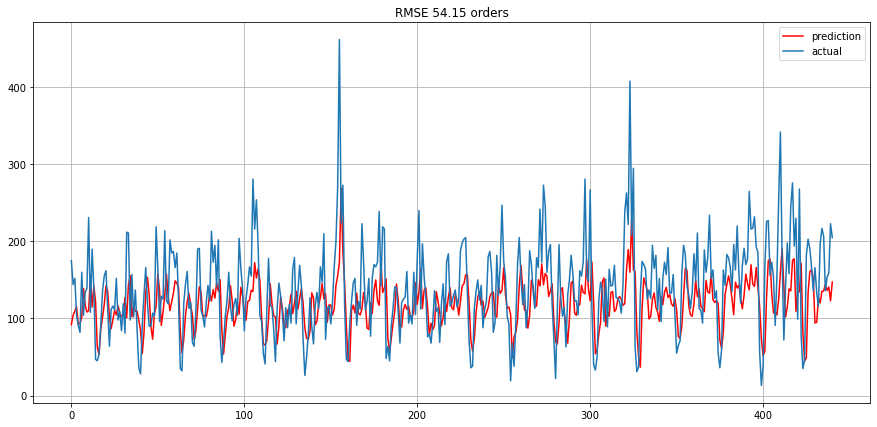

In [24]:
model_rfr = RandomForestRegressor(**best_params_rfr)
ml(model_lr, X_train, y_train, X_test, y_test)

### KNeighborsRegressor

RMSE модели: 64.80021516544161


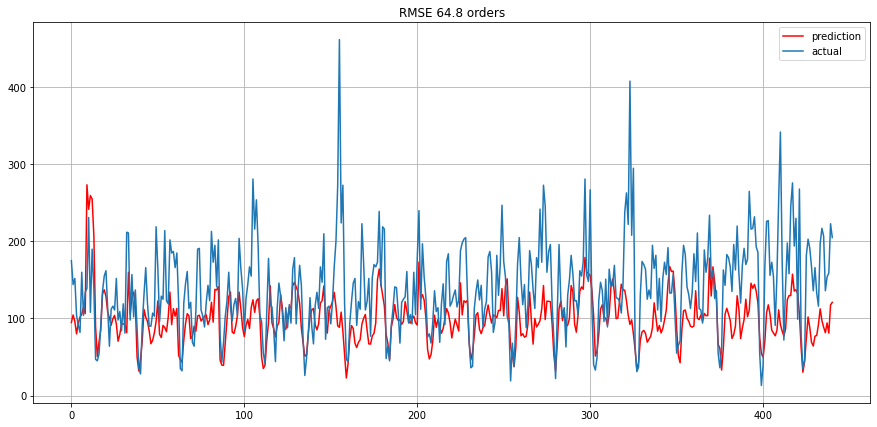

In [25]:
model_knn = KNeighborsRegressor(**best_params_knn)
ml(model_knn, X_train, y_train, X_test, y_test)

### LGBMRegressor

RMSE модели: 42.315572856080124


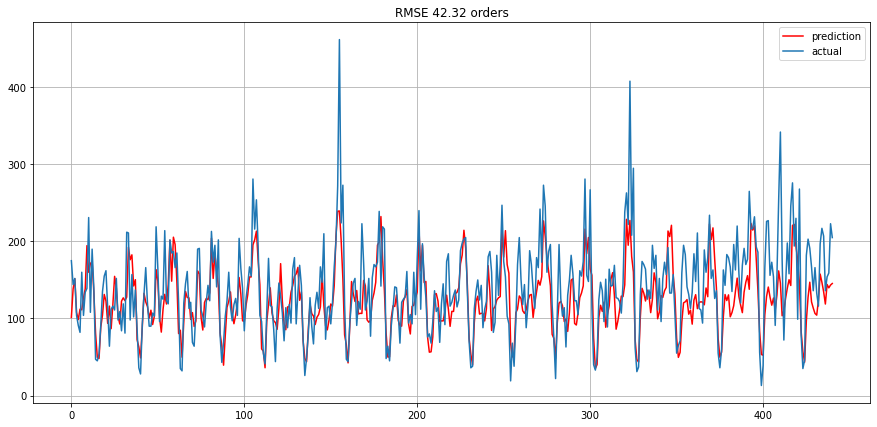

In [26]:
model_lgbm = lgb.LGBMRegressor(**best_param_lgbm)
ml(model_lgbm, X_train, y_train, X_test, y_test)

### Naive

Cоздадим наивное предсказание, которое предсказывыет предыдущее значение временного ряда. 

In [27]:
pred_previous = y_test.shift()
pred_previous.iloc[0] = y_train.iloc[-1]
rmse_naive = round(mean_squared_error(y_test, pred_previous)**0.5, 2)
print('RMSE наивного предсказания: ', rmse_naive)

RMSE наивного предсказания:  58.92


### Вывод

Наиболее точно предсказала количество заказов модель LGBMRegressor с RMSE 42.3. Также модель предсказывает лучше, чем предыдущее значение временного ряда. 

## ИТОГ

Были проанализированы данные, проведено ресемплирование и декомпозиция временного ряда. Для целей предсказания были обучены 4 варианта моделей, проведена кросс-валидация и получены лучшие гиперпараметры. В результате фианального тестирования наилучшую метрику RMSE 42.3 показала модель LGBMRegressor, которая к тому же предсказывает лучше, чем предыдущее значение временного ряда. 